In [1]:

import numpy as np 
import pandas as pd 
import os
import cv2

## Labels

In [3]:
labels = os.listdir(r"/Volumes/Untitled 2/driver_drowsiness_system/train")

In [4]:
labels

['.DS_Store', 'Closed', 'no_yawn', 'yawn', 'Open']

## Visualize A random image

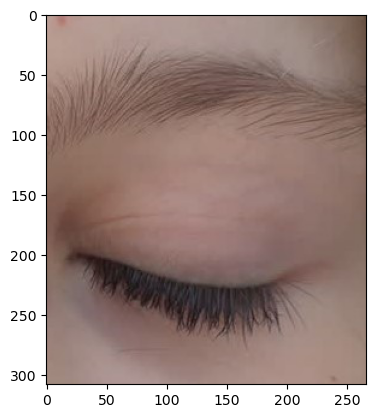

In [7]:
import matplotlib.pyplot as plt
plt.imshow(plt.imread(r"/Volumes/Untitled 2/driver_drowsiness_system/train/Closed/_61.jpg"))

## Image array

In [10]:
a = plt.imread(r"/Volumes/Untitled 2/driver_drowsiness_system/train/yawn/663.jpg")

## Image shape

In [11]:
a.shape

(480, 640, 3)

## Visualize yawn image(Background is unnecessary. We need only face image array) 


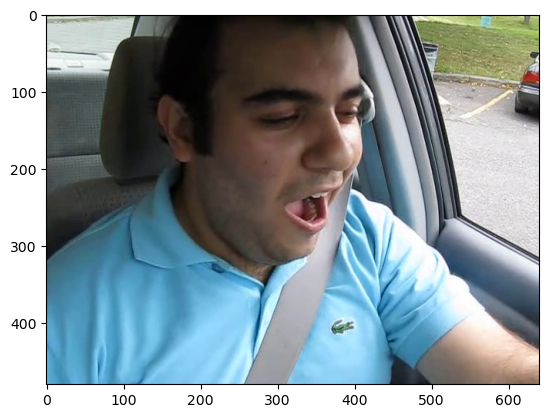

In [12]:
plt.imshow(plt.imread(r"/Volumes/Untitled 2/driver_drowsiness_system/train/yawn/663.jpg"))

## Take only face(For yawn and not_yawn)

In [13]:
def face_for_yawn(direc=r"/Volumes/Untitled 2/driver_drowsiness_system/train", face_cas_path=r"/Volumes/Untitled 2/driver_drowsiness_system/data/haarcascade_frontalface_default.xml"):
    yaw_no = []
    IMG_SIZE = 145
    categories = ["yawn", "no_yawn"]
    for category in categories:
        path_link = os.path.join(direc, category)
        class_num1 = categories.index(category)
        print(class_num1)
        for image in os.listdir(path_link):
            image_array = cv2.imread(os.path.join(path_link, image), cv2.IMREAD_COLOR)
            face_cascade = cv2.CascadeClassifier(face_cas_path)
            faces = face_cascade.detectMultiScale(image_array, 1.3, 5)
            for (x, y, w, h) in faces:
                img = cv2.rectangle(image_array, (x, y), (x+w, y+h), (0, 255, 0), 2)
                roi_color = img[y:y+h, x:x+w]
                resized_array = cv2.resize(roi_color, (IMG_SIZE, IMG_SIZE))
                yaw_no.append([resized_array, class_num1])
    return yaw_no


yawn_no_yawn = face_for_yawn()

0
1


## For Closed and Open eye

In [14]:
def get_data(dir_path=r"/Volumes/Untitled 2/driver_drowsiness_system/train",
              face_cas=r"/Volumes/Untitled 2/driver_drowsiness_system/data/haarcascade_frontalface_default.xml",
              eye_cas=r"/Volumes/Untitled 2/driver_drowsiness_system/data/haarcascade_eye.xml"):
    labels = ['Closed', 'Open']
    IMG_SIZE = 145
    data = []
    for label in labels:
        path = os.path.join(dir_path, label)
        class_num = labels.index(label)
        class_num +=2
        print(class_num)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                data.append([resized_array, class_num])
            except Exception as e:
                print(e)
    return data

In [15]:
data_train = get_data()

2
3


## Extend data and Convert array

In [16]:
def append_data():
#     total_data = []
    yaw_no = face_for_yawn()
    data = get_data()
    yaw_no.extend(data)
    return np.array(yaw_no)

## New variable to store

In [ ]:
new_data = append_data()

## Separate label and features

In [ ]:
X = []
y = []
for feature, label in new_data:
    X.append(feature)
    y.append(label)

## Reshape the Array

In [14]:
X = np.array(X)
X = X.reshape(-1, 145, 145, 3)

## LabelBinarizer

In [15]:
from sklearn.preprocessing import LabelBinarizer
label_bin = LabelBinarizer()
y = label_bin.fit_transform(y)

## Label array

In [16]:
y = np.array(y)

## Train Test split

In [17]:
from sklearn.model_selection import train_test_split
seed = 42
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_size)

## Length of X_test

In [18]:
len(X_test)

578

## Import some dependencies

In [19]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

## Data Augmentation

In [20]:
train_generator = ImageDataGenerator(rescale=1/255, zoom_range=0.2, horizontal_flip=True, rotation_range=30)
test_generator = ImageDataGenerator(rescale=1/255)


#train_generator = tf.data.Dataset.from_tensor_slices((X_train, y_train))
#test_generator = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_generator = train_generator.flow(np.array(X_train), y_train, shuffle=False)
test_generator = test_generator.flow(np.array(X_test), y_test, shuffle=False)

# Model

In [21]:
model = Sequential()

model.add(Conv2D(256, (3, 3), activation="relu", input_shape=(145,145,3)))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="softmax"))

model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 143, 143, 256)     7168      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 71, 71, 256)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 69, 69, 128)       295040    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 34, 34, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        73792     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 32)        1

In [22]:
history = model.fit(train_generator, epochs=50, validation_data=test_generator, shuffle=True, validation_steps=len(test_generator))

Epoch 1/50
43/43 [==============================] - 422s 10s/step - loss: 1.1787 - accuracy: 0.4595 - val_loss: 0.8622 - val_accuracy: 0.6747
Epoch 2/50
43/43 [==============================] - 412s 10s/step - loss: 0.6066 - accuracy: 0.7506 - val_loss: 0.6524 - val_accuracy: 0.7180
Epoch 3/50
43/43 [==============================] - 408s 9s/step - loss: 0.4214 - accuracy: 0.8411 - val_loss: 0.3382 - val_accuracy: 0.8668
Epoch 4/50
43/43 [==============================] - 334s 8s/step - loss: 0.3222 - accuracy: 0.8656 - val_loss: 0.4703 - val_accuracy: 0.8270
Epoch 5/50
43/43 [==============================] - 257s 6s/step - loss: 0.3199 - accuracy: 0.8708 - val_loss: 0.2397 - val_accuracy: 0.9048
Epoch 6/50
43/43 [==============================] - 247s 6s/step - loss: 0.2934 - accuracy: 0.8775 - val_loss: 0.2595 - val_accuracy: 0.8858
Epoch 7/50
43/43 [==============================] - 6473s 154s/step - loss: 0.2589 - accuracy: 0.9035 - val_loss: 0.2098 - val_accuracy: 0.9048
Epoch 8/

## History

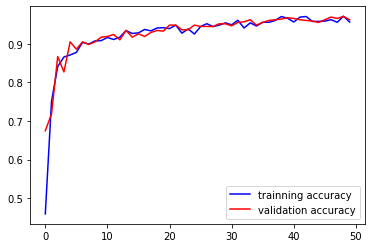

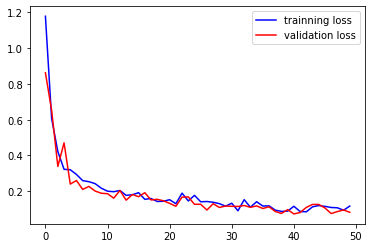

In [23]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, "b", label="trainning accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.show()

plt.plot(epochs, loss, "b", label="trainning loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.show()

## Save Model

In [24]:
model.save("drowiness_new7.h5")

In [25]:
model.save("drowiness_new7.model")

INFO:tensorflow:Assets written to: drowiness_new7.model\assets


# Prediction

In [26]:
prediction = model.predict_classes(X_test)

C:\Users\WINDOWS10\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [27]:
prediction

array([2, 3, 2, 3, 1, 3, 3, 2, 0, 2, 3, 3, 3, 2, 2, 2, 3, 0, 0, 3, 2, 3,
       2, 0, 0, 2, 2, 2, 2, 2, 3, 2, 3, 2, 0, 3, 3, 2, 0, 3, 3, 3, 2, 3,
       2, 2, 3, 3, 2, 3, 3, 0, 2, 1, 3, 3, 2, 2, 2, 0, 3, 3, 0, 2, 2, 3,
       2, 3, 2, 2, 1, 3, 3, 3, 2, 0, 0, 3, 0, 3, 2, 0, 3, 2, 2, 2, 2, 0,
       3, 3, 2, 3, 3, 3, 1, 0, 3, 0, 3, 3, 3, 0, 3, 0, 2, 3, 2, 0, 2, 0,
       0, 1, 2, 0, 0, 3, 3, 3, 2, 2, 3, 3, 2, 0, 1, 2, 3, 3, 2, 0, 3, 3,
       0, 3, 1, 2, 3, 3, 2, 0, 2, 2, 2, 0, 3, 3, 2, 3, 2, 0, 2, 3, 3, 3,
       3, 1, 1, 0, 3, 1, 3, 2, 2, 3, 2, 3, 3, 2, 3, 2, 3, 1, 2, 0, 3, 2,
       2, 2, 0, 2, 3, 0, 2, 0, 3, 2, 3, 0, 2, 0, 0, 3, 2, 2, 3, 3, 2, 0,
       3, 2, 3, 0, 2, 0, 0, 1, 2, 3, 2, 0, 3, 1, 2, 2, 2, 2, 1, 3, 0, 0,
       1, 0, 2, 3, 3, 3, 3, 0, 1, 2, 0, 0, 3, 3, 1, 3, 3, 0, 3, 3, 0, 1,
       0, 0, 3, 3, 3, 3, 3, 2, 3, 3, 2, 3, 2, 0, 2, 2, 2, 0, 3, 2, 2, 2,
       3, 2, 2, 0, 2, 3, 2, 2, 2, 3, 3, 3, 3, 3, 0, 0, 0, 3, 3, 3, 3, 2,
       2, 1, 2, 2, 2, 3, 2, 0, 2, 2, 1, 3, 2, 3, 1,

# classification report

In [28]:
labels_new = ["yawn", "no_yawn", "Closed", "Open"]

In [29]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test, axis=1), prediction, target_names=labels_new))

              precision    recall  f1-score   support

        yawn       0.63      0.95      0.76        63
     no_yawn       0.93      0.54      0.68        74
      Closed       0.94      0.98      0.96       215
        Open       0.98      0.94      0.96       226

    accuracy                           0.90       578
   macro avg       0.87      0.85      0.84       578
weighted avg       0.92      0.90      0.90       578



# predicting function

In [30]:
labels_new = ["yawn", "no_yawn", "Closed", "Open"]
IMG_SIZE = 145
def prepare(filepath, face_cas="../input/prediction-images/haarcascade_frontalface_default.xml"):
    img_array = cv2.imread(filepath, cv2.IMREAD_COLOR)
    img_array = img_array / 255
    resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return resized_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

model = tf.keras.models.load_model("./drowiness_new6.h5")

# Prediction 
## 0-yawn, 1-no_yawn, 2-Closed, 3-Open

In [31]:
# prepare("../input/drowsiness-dataset/train/no_yawn/1068.jpg")
prediction = model.predict([prepare(r"archive\train\no_yawn\1067.jpg")])
np.argmax(prediction)

1

In [32]:
prediction = model.predict([prepare(r"archive\train\Closed\_101.jpg")])
np.argmax(prediction)

2

In [33]:
prediction = model.predict([prepare(r"archive\train\Closed\_104.jpg")])
np.argmax(prediction)

2

In [34]:
prediction = model.predict([prepare(r"archive\train\yawn\12.jpg")])
np.argmax(prediction)


0